In [98]:
import gzip         # for reading .pkl.gz
import pickle       # to load the pickled dicts
import numpy as np  # for arrays, math
import matplotlib.pyplot as plt  # for plotting
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
from scipy.signal import find_peaks, peak_prominences, peak_widths
import matplotlib.cm as cm



In [99]:
def mesh_index_to_km(x):
    return (x / 299) * 110

def km_to_mesh_index(x):
    return (x / 110) * 299

# Maximum Accumulation

Grounding Line Plot - Amax = 5


In [100]:
gl_run_title_amax5 = str("Grounding Line Evolution Over Time - Max Accumulation = 5 m/yr")
amax5 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_16__15_13_21.pkl.gz"
with gzip.open(amax5, 'rb') as f:
    DATA_dict_amax5 = pickle.load(f)

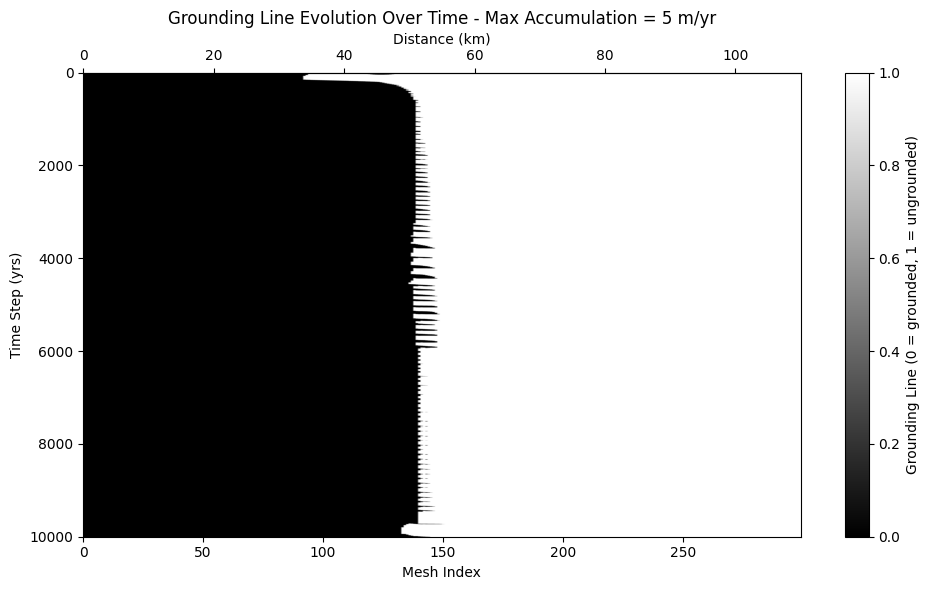

In [101]:
GL_dict = DATA_dict_amax5['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax5)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [102]:
gl_positions_amax5 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax5.append(idx)

gl_positions_amax5 = np.array(gl_positions_amax5)
GL_km_amax5 = mesh_index_to_km(gl_positions_amax5)



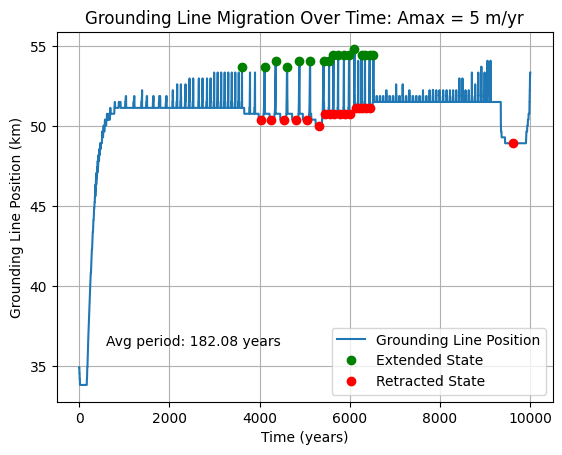

Mean cycle period: 182.08 years
[501.5696122  245.92848278 252.60618359 273.46352772 235.5396799
 301.31419611 120.49268564  98.20193177 103.0416729  127.62550512
 112.69708692 121.60835994 156.58010199  76.18826828 101.95987669
  84.52490585]
Mean advance amplitude: 54.23 km
[53.71237458 53.71237458 54.08026756 53.71237458 54.08026756 54.08026756
 54.08026756 54.08026756 54.44816054 54.44816054 54.44816054 54.44816054
 54.81605351 54.44816054 54.44816054 54.44816054 54.44816054]
Mean retreat amplitude: 50.63 km
[50.40133779 50.40133779 50.40133779 50.40133779 50.40133779 50.03344482
 50.76923077 50.76923077 50.76923077 50.76923077 50.76923077 50.76923077
 51.13712375 51.13712375 51.13712375 51.13712375 51.13712375 48.92976589]


In [103]:
peaks_amax5, _ = find_peaks(GL_km_amax5, prominence=3) 
troughs_amax5, _ = find_peaks(-GL_km_amax5, prominence=3)     
periods_amax5 = np.diff(np.array(time)[peaks_amax5])
adv_dists_amax5 = GL_km_amax5[peaks_amax5]
ret_dists_amax5 = GL_km_amax5[troughs_amax5]


plt.plot(time, GL_km_amax5, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax5], GL_km_amax5[peaks_amax5], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax5], GL_km_amax5[troughs_amax5], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax5):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 5 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax5):.2f} years")
print(periods_amax5)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax5):.2f} km")
print(adv_dists_amax5)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax5):.2f} km")
print(ret_dists_amax5)


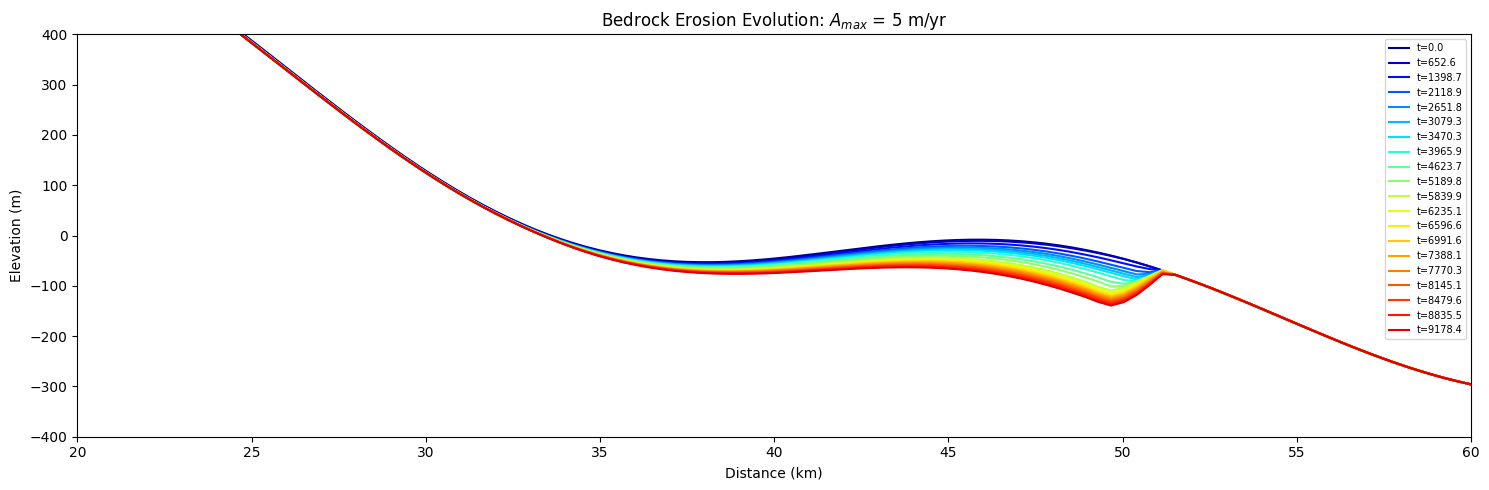

In [104]:
bed_dict = DATA_dict_amax5['bed_dict']
num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.jet

fig, ax1 = plt.subplots(figsize=(15,5))

for i, t in enumerate(time):
    if i % 400 != 0:  
        continue

    bed = bed_dict[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Bedrock Erosion Evolution: $A_{max}$ = 5 m/yr")
# plt.gca().invert_xaxis() 
plt.legend(loc="upper right", fontsize=7)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.xlim(20,60)
plt.ylim(-400,400)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/Amax/GL_Plots/Relationship_Plots/Bedrock_Evo_amax5.svg", format ="svg", bbox_inches='tight')

Grounding Line Plot - Amax = 6


In [105]:
gl_run_title_amax6 = str("Grounding Line Evolution Over Time - Max Accumulation = 6 m/yr")
amax6 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_16__14_32_19.pkl.gz"
with gzip.open(amax6, 'rb') as f:
    DATA_dict_amax6 = pickle.load(f)

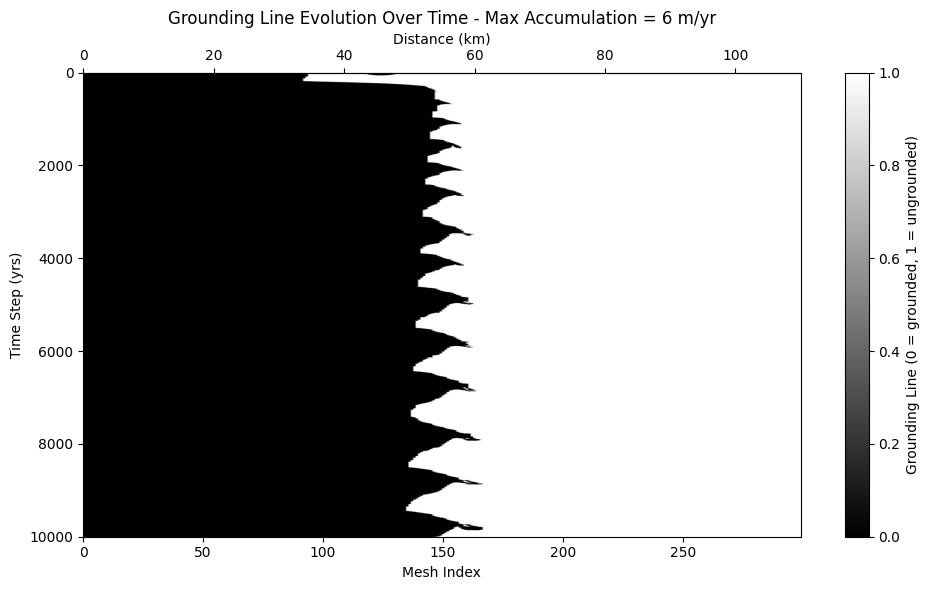

In [106]:
GL_dict = DATA_dict_amax6['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax6)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [107]:
gl_positions_amax6 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax6.append(idx)

gl_positions_amax6 = np.array(gl_positions_amax6)
GL_km_amax6 = mesh_index_to_km(gl_positions_amax6)



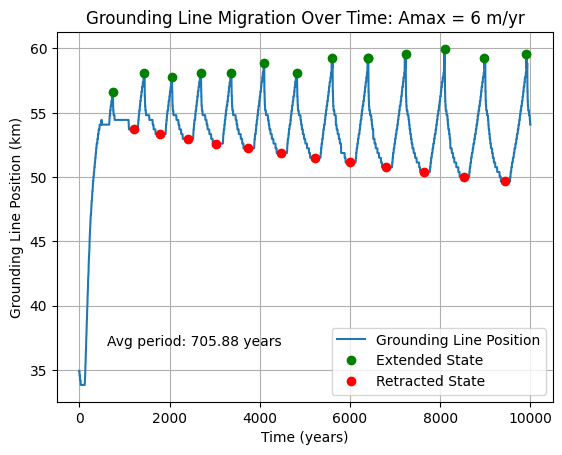

Mean cycle period: 705.88 years
[698.71853397 612.66647617 639.31512607 674.54851028 733.61269392
 720.65963102 777.66274421 795.11309274   9.57782899 833.94648599
 866.66492986 880.33453698 933.60409609]
Mean advance amplitude: 58.71 km
[56.65551839 58.1270903  57.75919732 58.1270903  58.1270903  58.86287625
 58.1270903  59.23076923 59.23076923 59.23076923 59.59866221 59.96655518
 59.23076923 59.59866221]
Mean retreat amplitude: 51.69 km
[53.71237458 53.34448161 52.97658863 52.60869565 52.24080268 51.8729097
 51.50501672 51.13712375 50.76923077 50.40133779 50.03344482 49.66555184]


In [108]:
peaks_amax6, _ = find_peaks(GL_km_amax6, prominence=2) 
troughs_amax6, _ = find_peaks(-GL_km_amax6, prominence=2)     
periods_amax6 = np.diff(np.array(time)[peaks_amax6])
adv_dists_amax6 = GL_km_amax6[peaks_amax6]
ret_dists_amax6 = GL_km_amax6[troughs_amax6]


plt.plot(time, GL_km_amax6, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax6], GL_km_amax6[peaks_amax6], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax6], GL_km_amax6[troughs_amax6], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax6):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 6 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax6):.2f} years")
print(periods_amax6)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax6):.2f} km")
print(adv_dists_amax6)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax6):.2f} km")
print(ret_dists_amax6)


Grounding Line Plot - Amax = 6.5


In [109]:
gl_run_title_amax6_5 = str("Grounding Line Evolution Over Time - Max Accumulation = 6.5 m/yr")
amax6_5 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_20__18_34_46.pkl.gz"
with gzip.open(amax6_5, 'rb') as f:
    DATA_dict_amax6_5 = pickle.load(f)

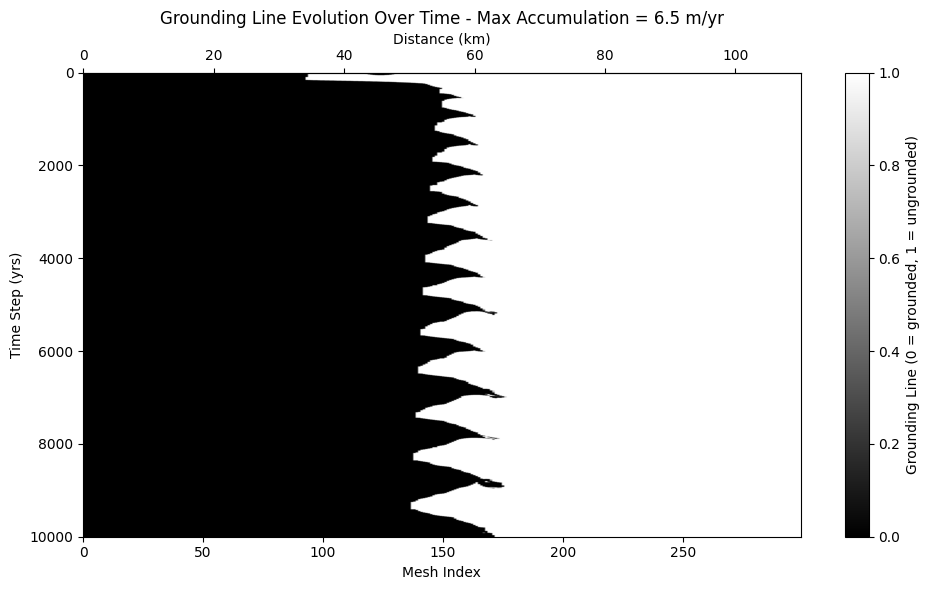

In [110]:
GL_dict = DATA_dict_amax6_5['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax6_5)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [111]:
gl_positions_amax6_5 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax6_5.append(idx)

gl_positions_amax6_5 = np.array(gl_positions_amax6_5)
GL_km_amax6_5 = mesh_index_to_km(gl_positions_amax6_5)



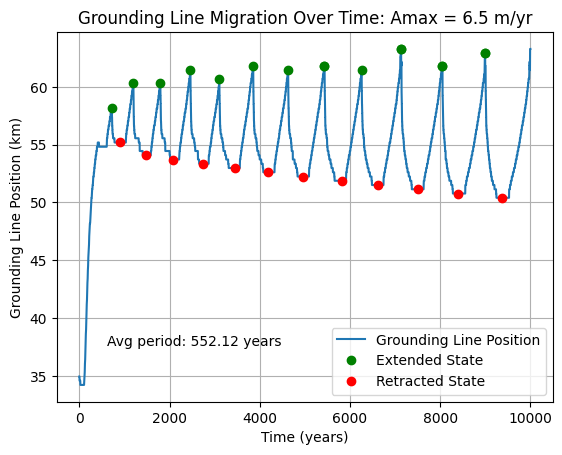

Mean cycle period: 552.12 years
[479.56074382 595.36385766 672.01769738 642.4813745  747.47330572
 775.85139393 792.49762726  10.89544073 826.69074873 866.05401265
   7.37447318 903.34936792  11.50835519 946.53723069   4.17212488]
Mean advance amplitude: 61.58 km
[58.1270903  60.33444816 60.33444816 61.43812709 60.70234114 61.80602007
 61.43812709 61.80602007 61.80602007 61.43812709 63.27759197 63.27759197
 61.80602007 61.80602007 62.909699   62.909699  ]
Mean retreat amplitude: 52.49 km
[55.18394649 54.08026756 53.71237458 53.34448161 52.97658863 52.60869565
 52.24080268 51.8729097  51.50501672 51.13712375 50.76923077 50.40133779]


In [112]:
peaks_amax6_5, _ = find_peaks(GL_km_amax6_5, prominence=2) 
troughs_amax6_5, _ = find_peaks(-GL_km_amax6_5, prominence=2)     
periods_amax6_5 = np.diff(np.array(time)[peaks_amax6_5])
adv_dists_amax6_5 = GL_km_amax6_5[peaks_amax6_5]
ret_dists_amax6_5 = GL_km_amax6_5[troughs_amax6_5]


plt.plot(time, GL_km_amax6_5, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax6_5], GL_km_amax6_5[peaks_amax6_5], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax6_5], GL_km_amax6_5[troughs_amax6_5], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax6_5):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 6.5 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax6_5):.2f} years")
print(periods_amax6_5)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax6_5):.2f} km")
print(adv_dists_amax6_5)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax6_5):.2f} km")
print(ret_dists_amax6_5)


Grounding Line Plot - Amax = 7


In [113]:
gl_run_title_amax7 = str("Grounding Line Evolution Over Time - Max Accumulation = 7 m/yr")
amax7 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_16__13_37_56.pkl.gz"
with gzip.open(amax7, 'rb') as f:
    DATA_dict_amax7 = pickle.load(f)

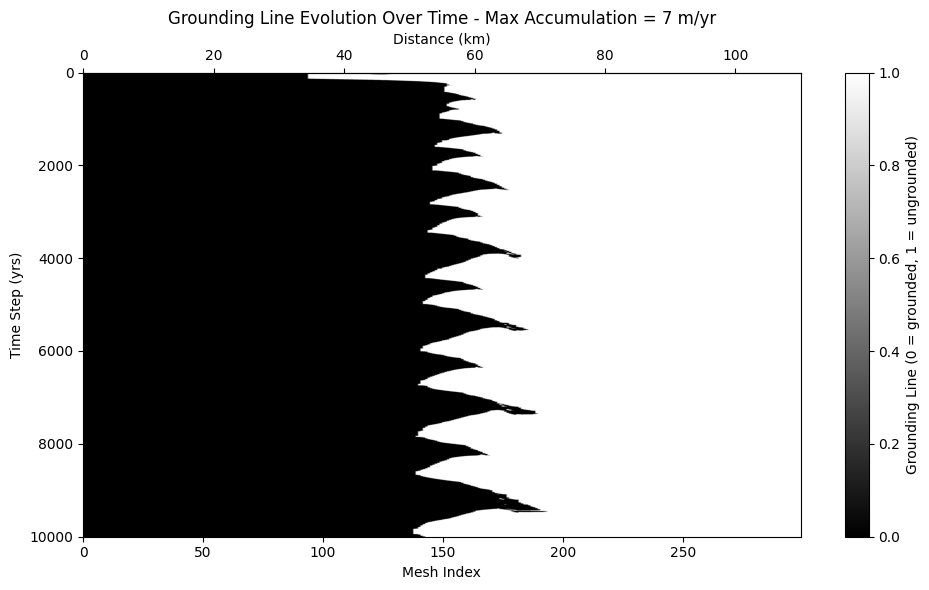

In [114]:
GL_dict = DATA_dict_amax7['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax7)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [115]:
gl_positions_amax7 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax7.append(idx)

gl_positions_amax7 = np.array(gl_positions_amax7)
GL_km_amax7 = mesh_index_to_km(gl_positions_amax7)



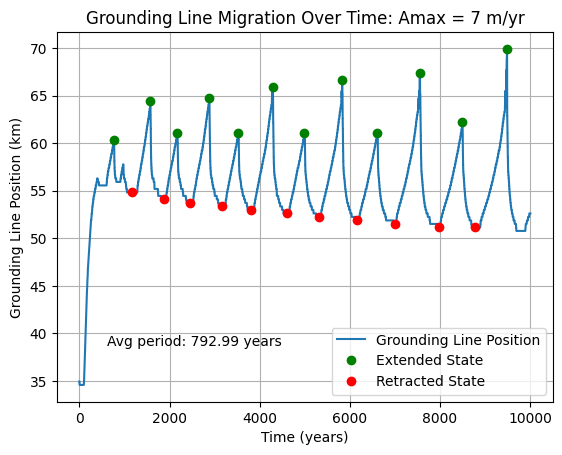

Mean cycle period: 792.99 years
[810.69220903 595.69132086 709.49029705 643.94588252 760.52828434
 706.46524477 836.26041301 780.08466833 944.20302351 946.60345946
 988.90497172]
Mean advance amplitude: 63.80 km
[60.33444816 64.3812709  61.07023411 64.74916388 61.07023411 65.85284281
 61.07023411 66.58862876 61.07023411 67.32441472 62.17391304 69.89966555]
Mean retreat amplitude: 52.68 km
[54.81605351 54.08026756 53.71237458 53.34448161 52.97658863 52.60869565
 52.24080268 51.8729097  51.50501672 51.13712375 51.13712375]


In [116]:
peaks_amax7, _ = find_peaks(GL_km_amax7, prominence=3) 
troughs_amax7, _ = find_peaks(-GL_km_amax7, prominence=3)     
periods_amax7 = np.diff(np.array(time)[peaks_amax7])
adv_dists_amax7 = GL_km_amax7[peaks_amax7]
ret_dists_amax7 = GL_km_amax7[troughs_amax7]


plt.plot(time, GL_km_amax7, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax7], GL_km_amax7[peaks_amax7], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax7], GL_km_amax7[troughs_amax7], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax7):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 7 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax7):.2f} years")
print(periods_amax7)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax7):.2f} km")
print(adv_dists_amax7)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax7):.2f} km")
print(ret_dists_amax7)


Grounding Line Plot - Amax = 7.5


In [117]:
gl_run_title_amax7_5 = str("Grounding Line Evolution Over Time - Max Accumulation = 7.5 m/yr")
amax7_5 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_20__20_43_15.pkl.gz"
with gzip.open(amax7_5, 'rb') as f:
    DATA_dict_amax7_5 = pickle.load(f)

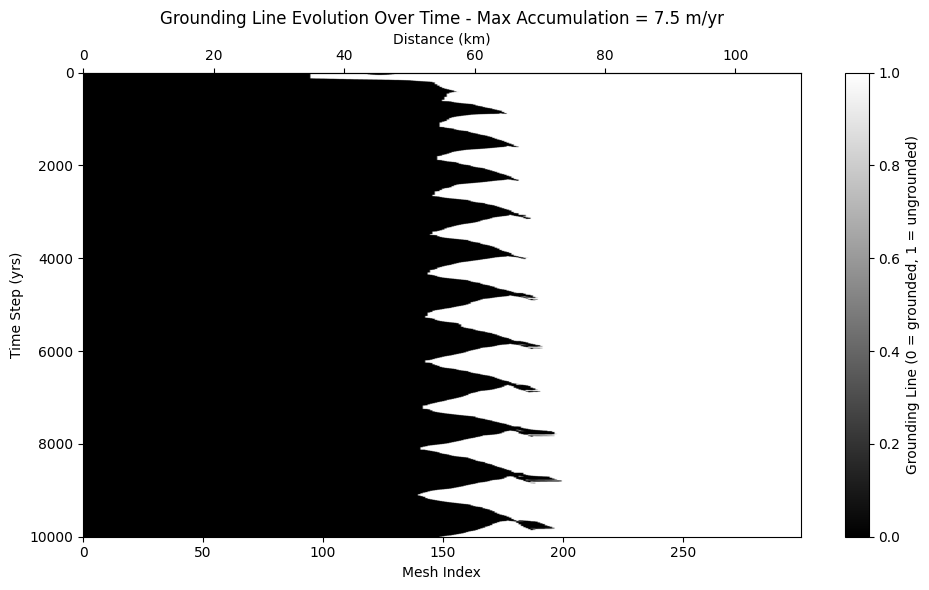

In [118]:
GL_dict = DATA_dict_amax7_5['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax7_5)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [119]:
gl_positions_amax7_5 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax7_5.append(idx)

gl_positions_amax7_5 = np.array(gl_positions_amax7_5)
GL_km_amax7_5 = mesh_index_to_km(gl_positions_amax7_5)



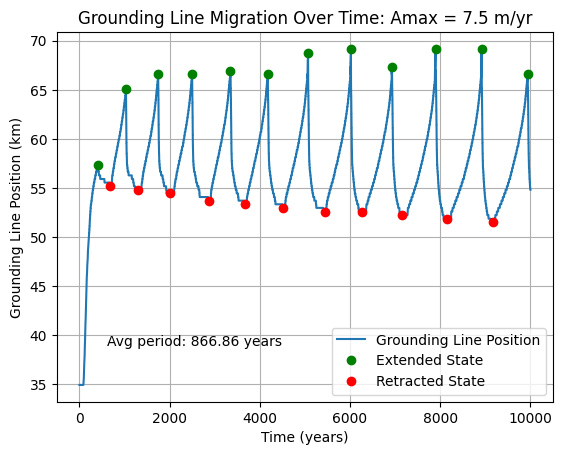

Mean cycle period: 866.86 years
[ 626.2314644   715.24441723  751.75739063  848.8757143   828.63161628
  894.17493429  951.63403196  910.56987433  965.57267872 1020.85119327
 1021.95709584]
Mean advance amplitude: 66.62 km
[57.39130435 65.11705686 66.58862876 66.58862876 66.95652174 66.58862876
 68.79598662 69.1638796  67.32441472 69.1638796  69.1638796  66.58862876]
Mean retreat amplitude: 53.21 km
[55.18394649 54.81605351 54.44816054 53.71237458 53.34448161 52.97658863
 52.60869565 52.60869565 52.24080268 51.8729097  51.50501672]


In [120]:
peaks_amax7_5, _ = find_peaks(GL_km_amax7_5, prominence=2) 
troughs_amax7_5, _ = find_peaks(-GL_km_amax7_5, prominence=2)     
periods_amax7_5 = np.diff(np.array(time)[peaks_amax7_5])
adv_dists_amax7_5 = GL_km_amax7_5[peaks_amax7_5]
ret_dists_amax7_5 = GL_km_amax7_5[troughs_amax7_5]


plt.plot(time, GL_km_amax7_5, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax7_5], GL_km_amax7_5[peaks_amax7_5], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax7_5], GL_km_amax7_5[troughs_amax7_5], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax7_5):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 7.5 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax7_5):.2f} years")
print(periods_amax7_5)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax7_5):.2f} km")
print(adv_dists_amax7_5)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax7_5):.2f} km")
print(ret_dists_amax7_5)


Grounding Line Plot - Amax = 8


In [121]:
gl_run_title_amax8 = str("Grounding Line Evolution Over Time - Max Accumulation = 8 m/yr")
amin16 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_03_14__14_04_13.pkl.gz"
with gzip.open(amin16, 'rb') as f:
    DATA_dict_amin16 = pickle.load(f)

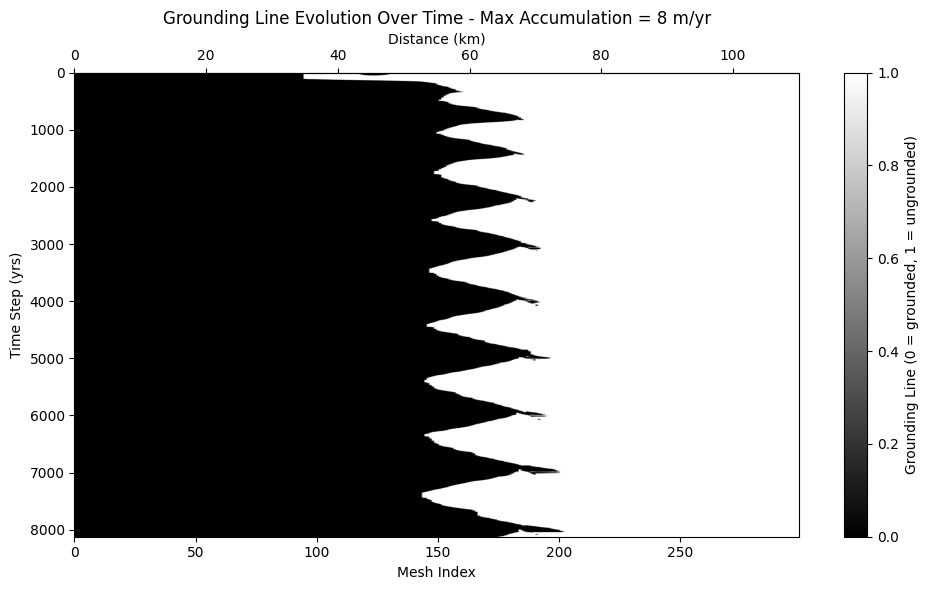

In [122]:
GL_dict = DATA_dict_amin16['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax8)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [123]:
gl_positions_amin16 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amin16.append(idx)

gl_positions_amin16 = np.array(gl_positions_amin16)
GL_km_amin16 = mesh_index_to_km(gl_positions_amin16)



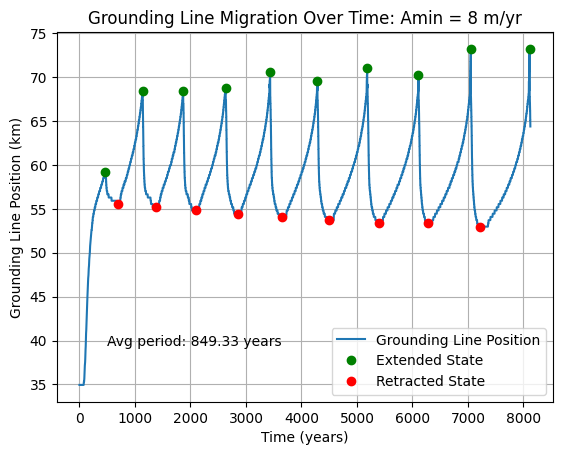

Mean cycle period: 849.33 years
[ 671.04104519  731.17664818  765.35723967  801.83053734  850.85569445
  897.86178343  923.5788195   943.37435896 1058.89407233]
Mean advance amplitude: 69.27 km
[59.23076923 68.42809365 68.42809365 68.79598662 70.63545151 69.53177258
 71.00334448 70.26755853 73.21070234 73.21070234]
Mean retreat amplitude: 54.16 km
[55.55183946 55.18394649 54.81605351 54.44816054 54.08026756 53.71237458
 53.34448161 53.34448161 52.97658863]


In [124]:
peaks_amin16, _ = find_peaks(GL_km_amin16, prominence=3) 
troughs_amin16, _ = find_peaks(-GL_km_amin16, prominence=3)     
periods_amin16 = np.diff(np.array(time)[peaks_amin16])
adv_dists_amin16 = GL_km_amin16[peaks_amin16]
ret_dists_amin16 = GL_km_amin16[troughs_amin16]


plt.plot(time, GL_km_amin16, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amin16], GL_km_amin16[peaks_amin16], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amin16], GL_km_amin16[troughs_amin16], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amin16):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amin = 8 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amin16):.2f} years")
print(periods_amin16)

print(f"Mean advance amplitude: {np.mean(adv_dists_amin16):.2f} km")
print(adv_dists_amin16)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amin16):.2f} km")
print(ret_dists_amin16)


Grounding Line Plot - Amax = 8.5


In [125]:
gl_run_title_amax8_5 = str("Grounding Line Evolution Over Time - Max Accumulation = 8.5 m/yr")
amax8_5 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_20__21_38_02.pkl.gz"
with gzip.open(amax8_5, 'rb') as f:
    DATA_dict_amax8_5 = pickle.load(f)

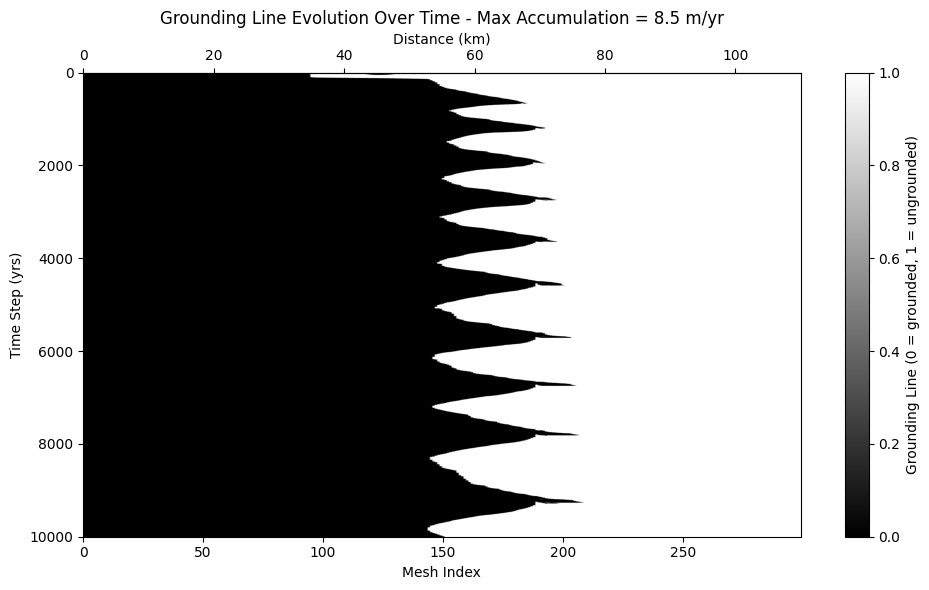

In [126]:
GL_dict = DATA_dict_amax8_5['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax8_5)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [127]:
gl_positions_amax8_5 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax8_5.append(idx)

gl_positions_amax8_5 = np.array(gl_positions_amax8_5)
GL_km_amax8_5 = mesh_index_to_km(gl_positions_amax8_5)



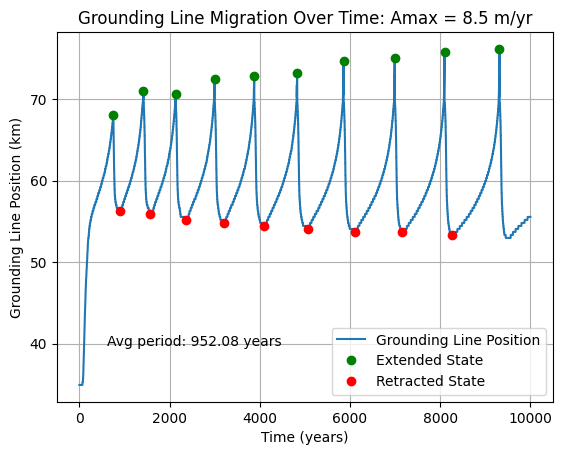

Mean cycle period: 952.08 years
[ 671.05974971  715.36031332  861.3772956   880.29212618  952.20755725
 1029.88140284 1133.4941161  1106.15925827 1218.90935421]
Mean advance amplitude: 72.99 km
[68.06020067 71.00334448 70.63545151 72.47491639 72.84280936 73.21070234
 74.68227425 75.05016722 75.78595318 76.15384615]
Mean retreat amplitude: 54.61 km
[56.28762542 55.91973244 55.18394649 54.81605351 54.44816054 54.08026756
 53.71237458 53.71237458 53.34448161]


In [128]:
peaks_amax8_5, _ = find_peaks(GL_km_amax8_5, prominence=3) 
troughs_amax8_5, _ = find_peaks(-GL_km_amax8_5, prominence=3)     
periods_amax8_5 = np.diff(np.array(time)[peaks_amax8_5])
adv_dists_amax8_5 = GL_km_amax8_5[peaks_amax8_5]
ret_dists_amax8_5 = GL_km_amax8_5[troughs_amax8_5]


plt.plot(time, GL_km_amax8_5, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax8_5], GL_km_amax8_5[peaks_amax8_5], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax8_5], GL_km_amax8_5[troughs_amax8_5], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax8_5):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 8.5 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax8_5):.2f} years")
print(periods_amax8_5)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax8_5):.2f} km")
print(adv_dists_amax8_5)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax8_5):.2f} km")
print(ret_dists_amax8_5)


Grounding Line Plot - Amax = 9


In [129]:
gl_run_title_amax9 = str("Grounding Line Evolution Over Time - Max Accumulation = 9 m/yr")
amax9 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_16__16_21_01.pkl.gz"
with gzip.open(amax9, 'rb') as f:
    DATA_dict_amax9 = pickle.load(f)

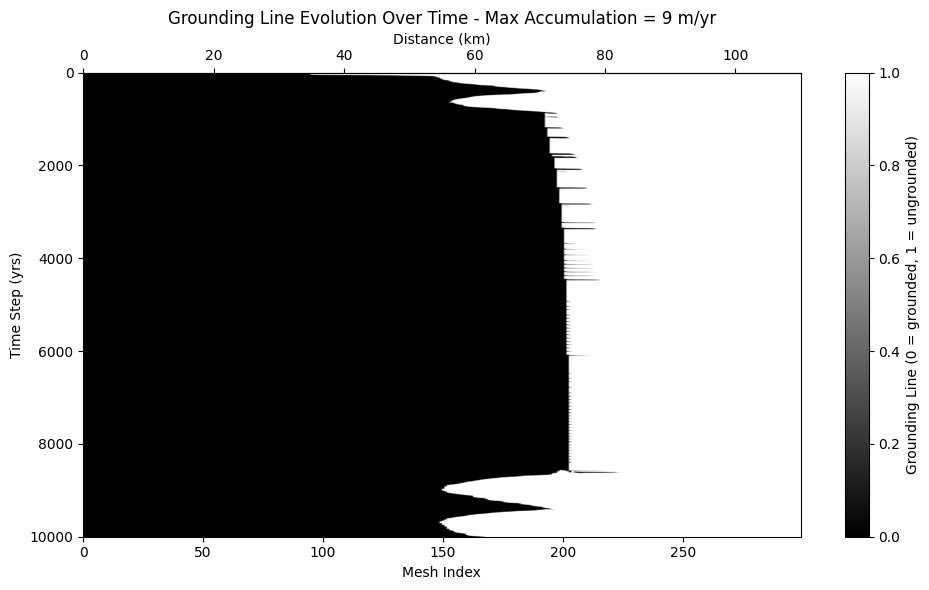

In [130]:
GL_dict = DATA_dict_amax9['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax9)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [131]:
gl_positions_amax9 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax9.append(idx)

gl_positions_amax9 = np.array(gl_positions_amax9)
GL_km_amax9 = mesh_index_to_km(gl_positions_amax9)



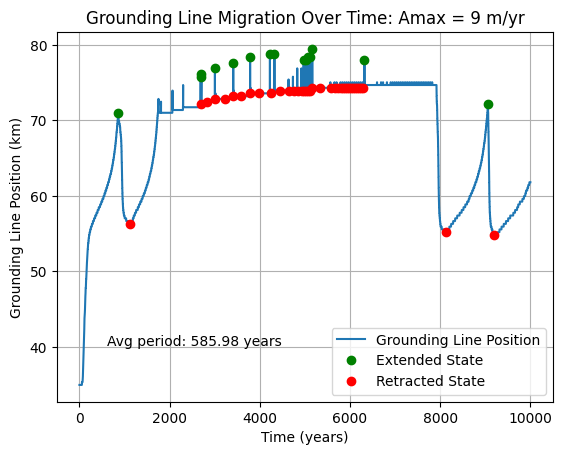

Mean cycle period: 585.98 years
[1831.09799912   16.57337245  299.31182765  406.07508377  374.53706408
  439.95523782   99.0601997   648.75028134   47.49335405   48.30994121
   46.81032772   47.86530732 1157.8185003  2740.00758083]
Mean advance amplitude: 77.04 km
[71.00334448 75.78595318 76.15384615 76.88963211 77.62541806 78.36120401
 78.72909699 78.72909699 77.99331104 77.99331104 78.36120401 78.36120401
 79.46488294 77.99331104 72.10702341]
Mean retreat amplitude: 72.44 km
[56.28762542 72.10702341 72.47491639 72.84280936 72.84280936 73.21070234
 73.21070234 73.57859532 73.57859532 73.57859532 73.94648829 73.94648829
 73.94648829 73.94648829 73.94648829 73.94648829 73.94648829 73.94648829
 73.94648829 74.31438127 74.31438127 74.31438127 74.31438127 74.31438127
 74.31438127 74.31438127 74.31438127 74.31438127 74.31438127 74.31438127
 74.31438127 74.31438127 74.31438127 74.31438127 74.31438127 74.31438127
 55.18394649 54.81605351]


In [132]:
peaks_amax9, _ = find_peaks(GL_km_amax9, prominence=3) 
troughs_amax9, _ = find_peaks(-GL_km_amax9, prominence=3)     
periods_amax9 = np.diff(np.array(time)[peaks_amax9])
adv_dists_amax9 = GL_km_amax9[peaks_amax9]
ret_dists_amax9 = GL_km_amax9[troughs_amax9]


plt.plot(time, GL_km_amax9, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax9], GL_km_amax9[peaks_amax9], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax9], GL_km_amax9[troughs_amax9], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax9):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 9 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax9):.2f} years")
print(periods_amax9)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax9):.2f} km")
print(adv_dists_amax9)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax9):.2f} km")
print(ret_dists_amax9)


Genuinely appears to just sit at the second bump stable for 1000's of years, building a big moraine and eroding the bedrock in a different spot than other variables. Then it gets bumped off the moraine and retreats far back 

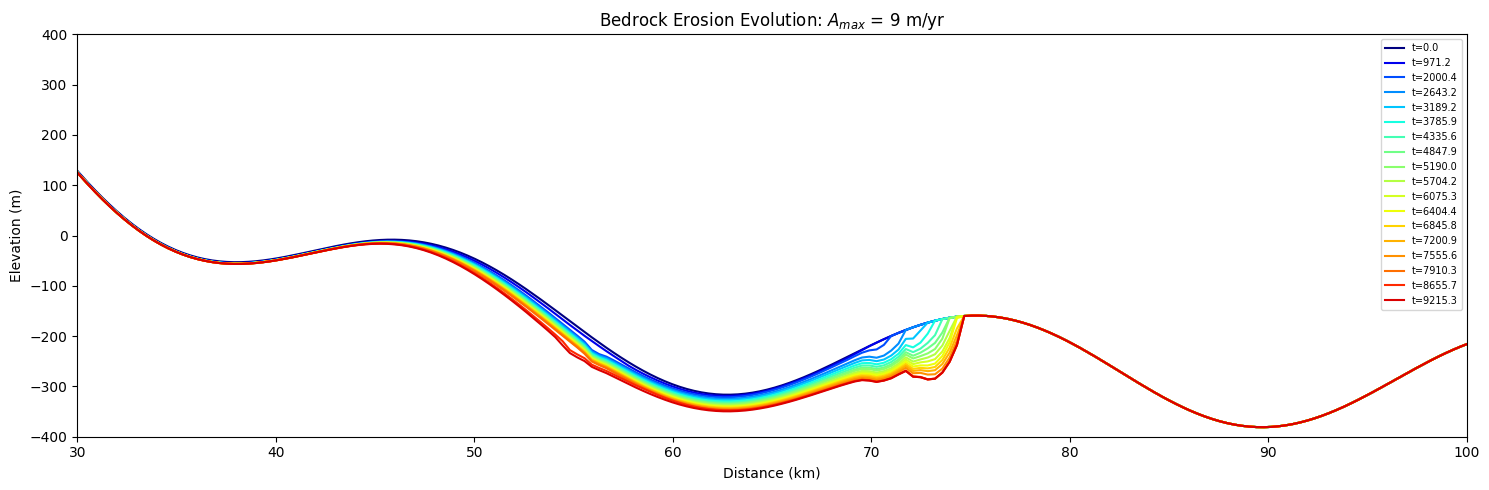

In [133]:
bed_dict = DATA_dict_amax9['bed_dict']
num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.jet

fig, ax1 = plt.subplots(figsize=(15,5))

for i, t in enumerate(time):
    if i % 800 != 0:  
        continue

    bed = bed_dict[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Bedrock Erosion Evolution: $A_{max}$ = 9 m/yr")
# plt.gca().invert_xaxis() 
plt.legend(loc="upper right", fontsize=7)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.xlim(30,100)
plt.ylim(-400,400)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/Amax/GL_Plots/Relationship_Plots/Bedrock_Evo_amax9.svg", format ="svg", bbox_inches='tight')

## Relationship Plots

In [134]:
title_amax_cycles = str("Number of Cycles Produced VS Maximum Accumulation")
amaxs = np.array([6,6.5,7,7.5,8,8.5])
amax_cycles = np.array([13, 12, 13,12, 11,10])
amax_coeff = np.polyfit(amaxs,amax_cycles, 1)
p_amax = np.poly1d(amax_coeff)
amax_y_trend = p_amax(amaxs)
R_2_amax =r2_score(amax_cycles,p_amax(amaxs))


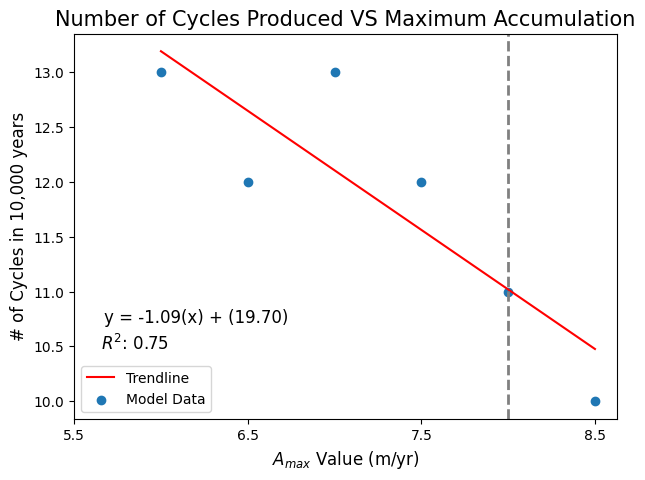

In [135]:
fig, ax1 = plt.subplots(figsize=(7,5))

plt.title(title_amax_cycles, fontsize = 15)
plt.plot(amaxs, amax_y_trend, color='red', label='Trendline')
plt.text(0.05, 0.18, f'$R^2$: {R_2_amax:.2f}', transform=plt.gca().transAxes, fontsize = 12)
plt.text(0.055, 0.25, f'y = {amax_coeff[0]:.2f}(x) + ({amax_coeff[1]:.2f})', transform=plt.gca().transAxes, fontsize = 12)
plt.axvline(x=8, color='gray', linestyle='--', linewidth=2)
plt.scatter(amaxs, amax_cycles, label = 'Model Data')
plt.xlabel("$A_{max}$ Value (m/yr)", fontsize = 12)
plt.ylabel("# of Cycles in 10,000 years", fontsize =12)
plt.xticks(np.arange(5.5, 9, 1.0))
plt.legend()

fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/Amax/GL_Plots/Relationship_Plots/#ofCycles_Amax.svg", format ="svg", bbox_inches='tight')

Variations in Cycle Period


In [136]:
amaxs = np.array([6,6.5,7,7.5,8, 8.5])

Period_list = [periods_amax6, periods_amax6_5, periods_amax7, periods_amax7_5, periods_amin16, periods_amax8_5]

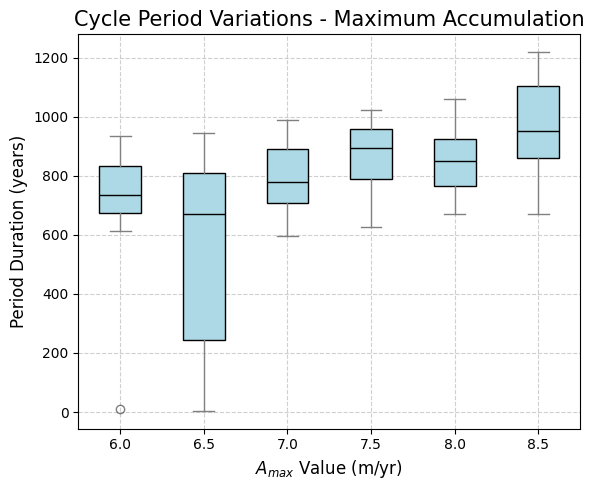

In [137]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(Period_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Cycle Period Variations - Maximum Accumulation", fontsize = 15)
ax.set_ylabel("Period Duration (years)", fontsize = 12)
plt.xlabel("$A_{max}$ Value (m/yr)", fontsize = 12)
ax.set_xticks(np.arange(1, len(amaxs) + 1))
ax.set_xticklabels(amaxs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/Amax/GL_Plots/Relationship_Plots/PeriodVariation_Amax.svg", format ="svg", bbox_inches='tight')

Variations in GL Extent - Advance 

In [138]:
amaxs = np.array([6,6.5,7,7.5,8, 8.5])
ExtPos_list =  [adv_dists_amax6, adv_dists_amax6_5, adv_dists_amax7,adv_dists_amax7_5, adv_dists_amin16, adv_dists_amax8_5]


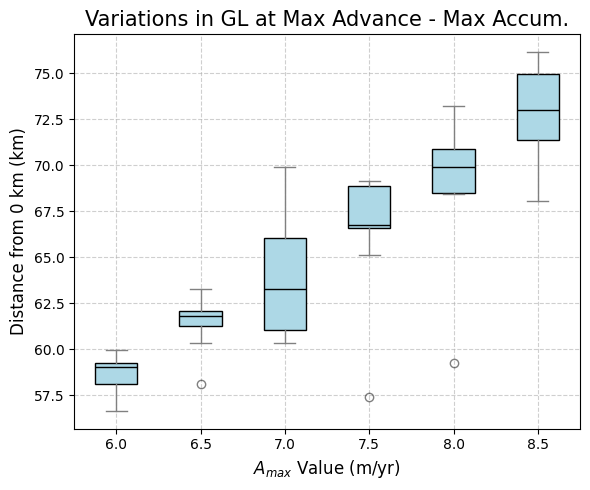

In [139]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Max Advance - Max Accum.", fontsize = 15)
ax.set_ylabel("Distance from 0 km (km)", fontsize = 12)
ax.set_xlabel("$A_{max}$ Value (m/yr)", fontsize = 12)
ax.set_xticks(np.arange(1, len(amaxs) + 1))
ax.set_xticklabels(amaxs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Variations in GL Extent - Retreat 

In [140]:
amaxs = np.array([6,6.5,7,7.5,8,8.5])
RetPos_list =  [ret_dists_amax6, ret_dists_amax6_5, ret_dists_amax7, ret_dists_amax7_5,  ret_dists_amin16, ret_dists_amax8_5]

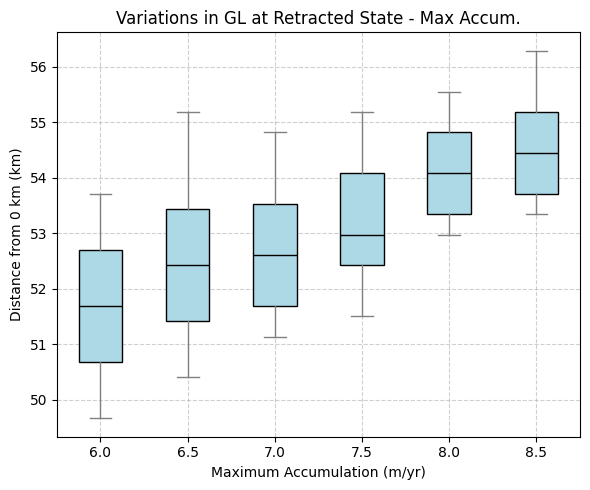

In [141]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Retracted State - Max Accum.")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Maximum Accumulation (m/yr)")
ax.set_xticks(np.arange(1, len(amaxs) + 1))
ax.set_xticklabels(amaxs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

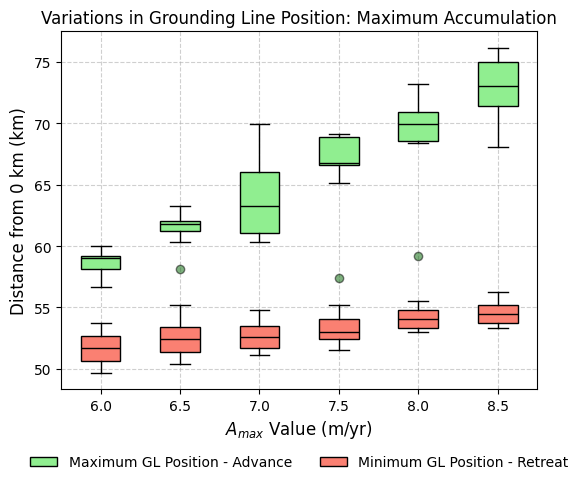

In [142]:
fig, ax = plt.subplots(figsize=(6, 5))

D2 = ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='salmon'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='salmon', alpha=0.5))

D1 = ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightgreen'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='darkgreen', alpha=0.5))

ax.set_title("Variations in Grounding Line Position: Maximum Accumulation", fontsize = 12)
ax.set_ylabel("Distance from 0 km (km)", fontsize = 12)
ax.set_xlabel("$A_{max}$ Value (m/yr)", fontsize = 12)
ax.legend([D1["boxes"][0], D2["boxes"][0]], ['Maximum GL Position - Advance', 'Minimum GL Position - Retreat'], loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=2, frameon=False)
ax.set_xticks(np.arange(1, len(amaxs) + 1))
ax.set_xticklabels(amaxs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/Amax/GL_Plots/Relationship_Plots/GL_Variation_Amax.svg", format ="svg", bbox_inches='tight')